In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import time

from dask.distributed import Client
from dask import delayed
from dask import compute

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import data_utils.data_analysis as data_analysis
import data_utils.pulse as pulse
import models.tools as models_tools
import models.rf as rf

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [3]:
#get the spectral coeeficients (as in the get shot num)
def get_coef(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    order2=df_input['order2'].loc[id_value]
    order3=df_input['order3'].loc[id_value]
    order4=df_input['order4'].loc[id_value]
    return order2, order3, order4

In [4]:
#Average shots with same input param
def shot_average(df_input,df_time):
    goodness_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    #wizz_list=[]
    #goodness_mean=[]
    wizz_mean=[]
    #emax_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            #goodness_list.append(row['goodness'])
            wizz_list=df_time.iloc[index].to_numpy()
            #print(wizz_list)
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                #goodness_list.append(row['goodness'])
                wizz_list=np.vstack([wizz_list,df_time.iloc[index].to_numpy()])
                #print(wizz_list)
                #ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                #integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the avg (from the previous shots)
                #goodness_mean.append(np.mean(goodness_list))
                wizz_mean.append(np.mean(wizz_list,axis=0))
                ##print(wizz_mean)
                ##print(counter)
                #emax_std.append(np.std(emax_list))
                #ecut_mean.append(np.mean(ecut_list))
                #ecut_std.append(np.std(ecut_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                
                #AND start the new batch
                #goodness_list=[row['goodness']]
                wizz_list=df_time.iloc[index].to_numpy()
                #ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                #integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_input_avg=pd.DataFrame()
    df_time_avg=pd.DataFrame(wizz_mean)
    df_input_avg['order2']=o2_list
    df_input_avg['order3']=o3_list
    df_input_avg['order4']=o4_list
    #df_input_avg['goodness mean']=goodness_mean
    #df_metrics_avg['Emax std']=emax_std
    return df_input_avg,df_time_avg

In [5]:
client = Client(n_workers=20)

In [6]:
client.cluster

LocalCluster(8b351196, 'tcp://127.0.0.1:37153', workers=20, threads=20, memory=31.02 GiB)

In [7]:
c = 299792458 ## speed of light in m/s

In [8]:
#read the file

In [9]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [10]:
# read the extra quantities for high res pulse reconstruction

In [11]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [12]:
df_spec_freq

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
1,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
2,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
3,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
4,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9498,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
9499,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
9500,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361
9501,333.033214,333.126435,333.219657,333.312878,333.4061,333.499321,333.592543,333.685764,333.778986,333.872207,...,427.373367,427.466589,427.55981,427.653032,427.746253,427.839475,427.932696,428.025918,428.119139,428.212361


### Reconstruct the pulse

In [13]:
shot_ind=2000
intensity=df_spec_int.loc[shot_ind].to_numpy()
frequency=df_spec_freq.loc[shot_ind].to_numpy()
phase=df_spec_phase.loc[shot_ind].to_numpy()

In [14]:
time = 100 ## time boundary in fs
time_bins=60
t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm

In [15]:
# =============================================================================
# Create the pulse
# =============================================================================
p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)

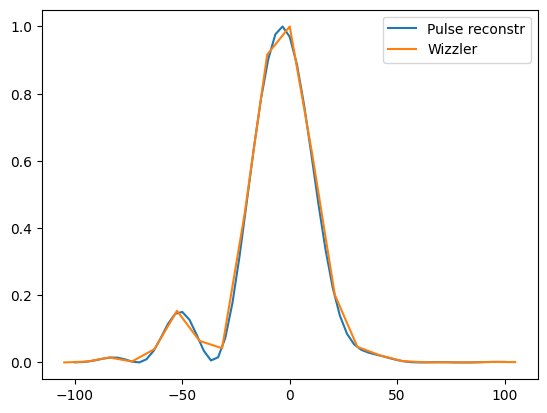

In [16]:
#plt.plot(p.time*1e15,p.intensity,label='Pulse reconstr') #in fs
plt.plot(t,p.intensity,label='Pulse reconstr') #in fs
plt.plot(df_time_val,df_time.iloc[shot_ind],label='Wizzler')
plt.legend()

In [17]:
#time in fs (it is the boundariy)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)
    

In [18]:
#time in fs (it is the boundariy)
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [19]:
%%time
t_100,df_pulse_100=pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 224.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 15.6 s, sys: 1.85 s, total: 17.4 s
Wall time: 19.3 s


In [20]:
%%time
t_50,df_pulse_50=pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=50)

CPU times: user 15.2 s, sys: 1.4 s, total: 16.6 s
Wall time: 17.6 s


In [21]:
%%time
t_200,df_pulse_200=pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=200)

CPU times: user 17.7 s, sys: 1.9 s, total: 19.6 s
Wall time: 22.9 s


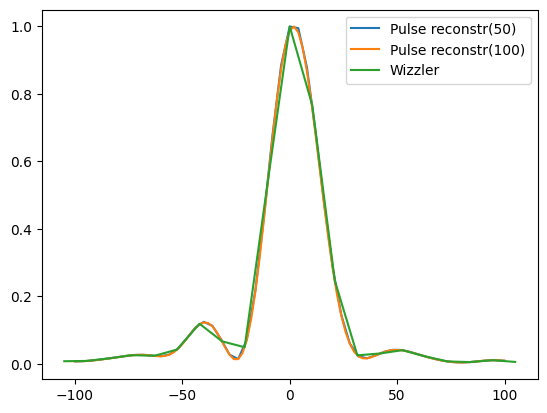

In [22]:
shot_ind=10
plt.plot(t_50,df_pulse_50.iloc[shot_ind],label='Pulse reconstr(50)') #in fs
plt.plot(t_100,df_pulse_100.iloc[shot_ind],label='Pulse reconstr(100)') #in fs
#plt.plot(t_200,df_pulse_200.iloc[shot_ind],label='Pulse reconstr(200)') #in fs
plt.plot(df_time_val,df_time.iloc[shot_ind],label='Wizzler')
plt.legend()

### Average same shots

In [23]:
df_input_avg,df_time_avg=shot_average(df_input,df_time)
df_input_avg,df_pulse_50_avg=shot_average(df_input,df_pulse_50)
df_input_avg,df_pulse_100_avg=shot_average(df_input,df_pulse_100)
df_input_avg,df_pulse_200_avg=shot_average(df_input,df_pulse_200)

## Train the forward model

In [24]:
def train_forward(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

### Train the original wizzler data (21 points)

In [25]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_avg,df_time_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [26]:
%%time
forward_model_rf,df_error_forward_rf=train_forward(df_input_avg,df_time_avg)

CPU times: user 1.1 s, sys: 23.1 ms, total: 1.13 s
Wall time: 1.07 s


In [27]:
y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

### Train the pulse with 50 points

In [28]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train_50, X_test_50, y_train_50, y_test_50=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_50_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_50_reset=y_test_50.reset_index(drop=True)

In [29]:
%%time
forward_model_rf_50,df_error_forward_rf_50=train_forward(df_input_avg,df_pulse_50_avg)

CPU times: user 733 ms, sys: 57.4 ms, total: 790 ms
Wall time: 721 ms


### Traint the pulse with 100 points

In [30]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train_100, X_test_100, y_train_100, y_test_100=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_100_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_100_reset=y_test_100.reset_index(drop=True)

In [31]:
%%time
forward_model_rf_100,df_error_forward_rf_100=train_forward(df_input_avg,df_pulse_100_avg)

CPU times: user 1.1 s, sys: 102 ms, total: 1.2 s
Wall time: 1.08 s


In [32]:
y_predict_forward_100=rf.make_rf_prediction(forward_model_rf_100,X_test_100)

Text(0.5, 1.0, 'RF Model Accuracy')

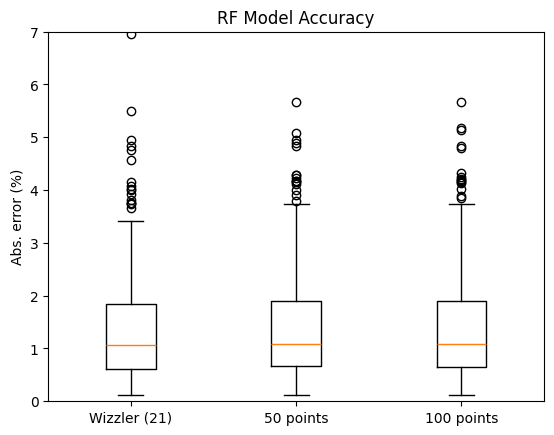

In [33]:
error_dist=[100*df_error_forward_rf,
           100*df_error_forward_rf_50,
           100*df_error_forward_rf_100]
labels=['Wizzler (21)','50 points','100 points']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('RF Model Accuracy')

In [34]:
#plot the predictions

In [35]:
def plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,y_predict_forward):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=get_coef(shot_index,y_test,df_input)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=3)
    #plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_forward[shot_index],label='Prediction (RF)',linewidth=3,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict_forward[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.text(35, 0.7, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(35, 0.6, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(35, 0.5, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend(loc='upper left')

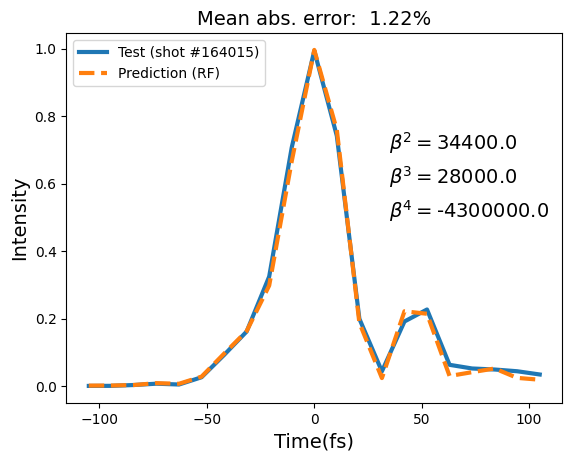

In [36]:
shot_index=159
plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,y_predict_forward)

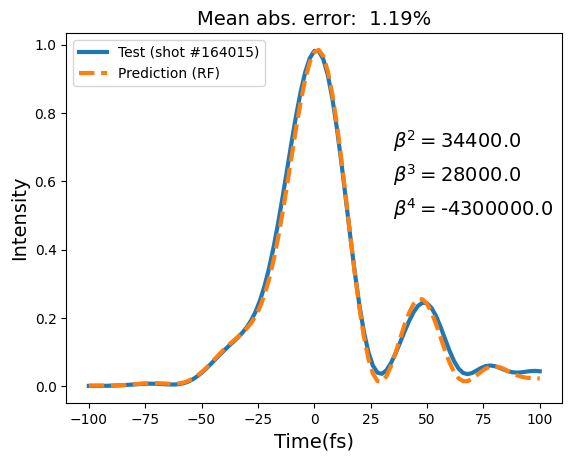

In [37]:
plot_example(shot_index,y_test_100,y_test_100_reset,df_input,t_100,y_predict_forward_100)

# Roundtrip model

In [38]:
def train_roundtrip(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #train roadtrip model
    rf_model_forward,rf_model_backward = models_tools.train_roundtrip_rf(X_train, X_test, y_train, y_test,
                                                            n_estimators, max_features,max_depth, random_state)
    #roundtrip prediction
    y_predict_rf_roundtrip=models_tools.roundtrip_rf_predict(y_test,rf_model_backward,rf_model_forward)

    #study the erro distribution
    df_error_roundtrip_rf=abs(y_test_reset-y_predict_rf_roundtrip)
    df_error_roundtrip_rf=df_error_roundtrip_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return rf_model_forward,rf_model_backward,df_error_roundtrip_rf

### Train the original wizzler data (21 points)

In [39]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_avg,df_time_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [40]:
%%time
rf_model_forward,rf_model_backward,df_error_roundtrip_rf=train_roundtrip(df_input_avg,df_time_avg)

CPU times: user 4.06 s, sys: 135 ms, total: 4.2 s
Wall time: 3.82 s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [41]:
#Predictions
y_predict_rf_roundtrip=models_tools.roundtrip_rf_predict(y_test,rf_model_backward,rf_model_forward)
X_predict_rf_backward=rf.make_rf_prediction(rf_model_backward,y_test)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Train the pulse with 50 points

In [42]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train_50, X_test_50, y_train_50, y_test_50=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_50_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_50_reset=y_test_50.reset_index(drop=True)

In [43]:
%%time
rf_model_forward_50,rf_model_backward_50,df_error_roundtrip_rf_50=train_roundtrip(df_input_avg,df_pulse_50_avg)

CPU times: user 8.63 s, sys: 229 ms, total: 8.86 s
Wall time: 7.96 s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [44]:
y_predict_rf_roundtrip_50=models_tools.roundtrip_rf_predict(y_test_50,rf_model_backward_50,rf_model_forward_50)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Train with 100 points

In [45]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train_100, X_test_100, y_train_100, y_test_100=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_100_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_100_reset=y_test_100.reset_index(drop=True)

In [46]:
%%time
rf_model_forward_100,rf_model_backward_100,df_error_roundtrip_rf_100=train_roundtrip(df_input_avg,df_pulse_100_avg)

CPU times: user 16.1 s, sys: 405 ms, total: 16.5 s
Wall time: 14.7 s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [47]:
y_predict_rf_roundtrip_100=models_tools.roundtrip_rf_predict(y_test_100,rf_model_backward_100,rf_model_forward_100)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [48]:
def plot_example_2(shot_index,y_test,y_test_reset,df_input,df_time_val,
                 y_predict,X_predict):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)

    #print the predicted and real input parameteres:
    #print(X_predict[shot_index])
    #print(df_input[df_input_clean['shot number']==shot_numb])

    o2_real,o3_real,o4_real=get_coef(shot_index,y_test,df_input)
    
    #o2_real=df_input[df_input['shot number']==shot_numb]['order2']
    #o3_real=df_input[df_input['shot number']==shot_numb]['order3']
    #o4_real=df_input[df_input['shot number']==shot_numb]['order4']
    
    min_order2=df_input['order2'].min()
    max_order2=df_input['order2'].max()

    min_order3=df_input['order3'].min()
    max_order3=df_input['order3'].max()

    min_order4=df_input['order4'].min()
    max_order4=df_input['order4'].max()
    #print(min_order2,max_order2)

    
    fig, ax = plt.subplots()
    
    ax.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=5)
    ax.plot(df_time_val,y_predict[shot_index],label='Prediction (Random  forest)',linewidth=5,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13)

    #Inset plot with the input parameters
    y_temp=[0]
    ax.figure.set_size_inches(9, 6.5)
    widht1d=2.3 #1d plot widht
    height1d=0.8
    bbox_left=140
    
    axin2 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,600])
    axin2.scatter(o2_real,y_temp,100,label='Test')
    axin2.scatter(X_predict[shot_index][0],y_temp,100,label='prediction',marker='s')
    axin2.spines['top'].set_visible(False)
    axin2.spines['right'].set_visible(False)
    axin2.spines['left'].set_visible(False)
    axin2.yaxis.set_visible(False)
    axin2.spines['bottom'].set_position('zero')
    axin2.set_xlabel(r'$\beta^{(2)}$',fontsize=12)
    axin2.set_xlim(min_order2,max_order2)
    axin2.patch.set_alpha(0.0)

    axin3 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,530])
    axin3.scatter(o3_real,y_temp,100,label='Test')
    axin3.scatter(X_predict[shot_index][1],y_temp,100,label='prediction',marker='s')
    axin3.spines['top'].set_visible(False)
    axin3.spines['right'].set_visible(False)
    axin3.spines['left'].set_visible(False)
    axin3.yaxis.set_visible(False)
    axin3.spines['bottom'].set_position('zero')
    axin3.set_xlabel(r'$\beta^{(3)}$',fontsize=12)
    axin3.set_xlim(min_order3,max_order3)
    axin3.patch.set_alpha(0.0)

    axin4 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,460])
    axin4.scatter(o4_real,y_temp,100,label='Test')
    axin4.scatter(X_predict[shot_index][2],y_temp,100,label='prediction',marker='s')
    axin4.spines['top'].set_visible(False)
    axin4.spines['right'].set_visible(False)
    axin4.spines['left'].set_visible(False)
    axin4.yaxis.set_visible(False)
    axin4.spines['bottom'].set_position('zero')
    axin4.set_xlabel(r'$\beta^{(4)}$',fontsize=12)
    axin4.set_xlim(min_order4,max_order4)
    axin4.patch.set_alpha(0.0)

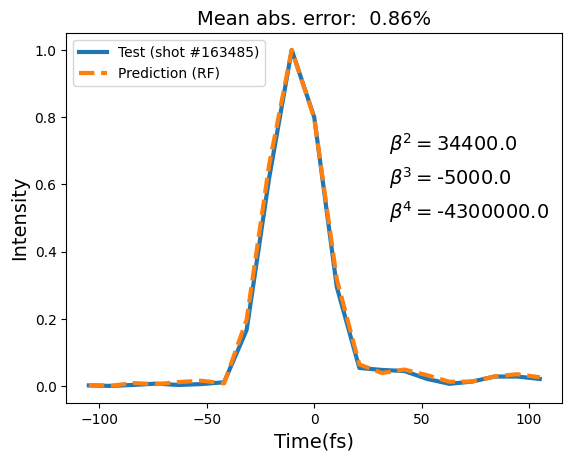

In [49]:
shot_index=102
plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,y_predict_rf_roundtrip)

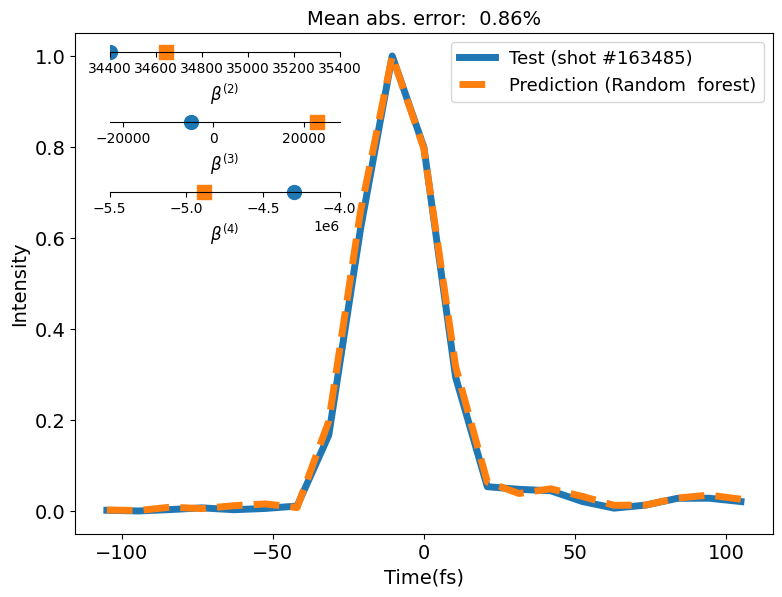

In [50]:
plot_example_2(shot_index,y_test,y_test_reset,df_input,df_time_val,
                 y_predict_rf_roundtrip,X_predict_rf_backward)

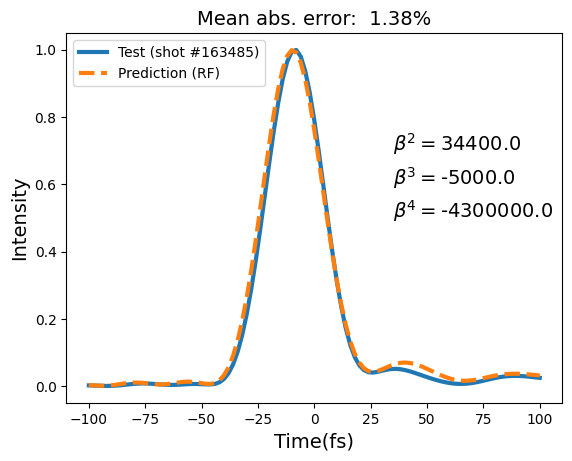

In [51]:
plot_example(shot_index,y_test_100,y_test_100_reset,df_input,t_100,y_predict_rf_roundtrip_100)

Text(0.5, 1.0, 'Roundtrip Model Accuracy')

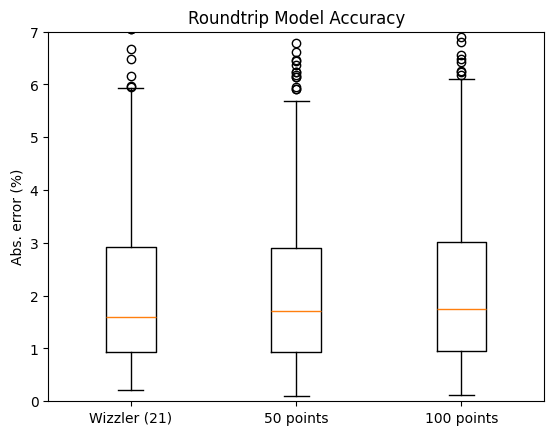

In [52]:
error_dist=[100*df_error_roundtrip_rf,
           100*df_error_roundtrip_rf_50,
           100*df_error_roundtrip_rf_100]
labels=['Wizzler (21)','50 points','100 points']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('Roundtrip Model Accuracy')

# Analysis on backward predictions

In [53]:
X_test['order2']

916     35200.0
285     34600.0
766     35100.0
885     35200.0
2       34400.0
         ...   
306     34600.0
518     34800.0
548     34900.0
817     35100.0
1135    35400.0
Name: order2, Length: 357, dtype: float64

Text(0.5, 1.0, 'Order 2')

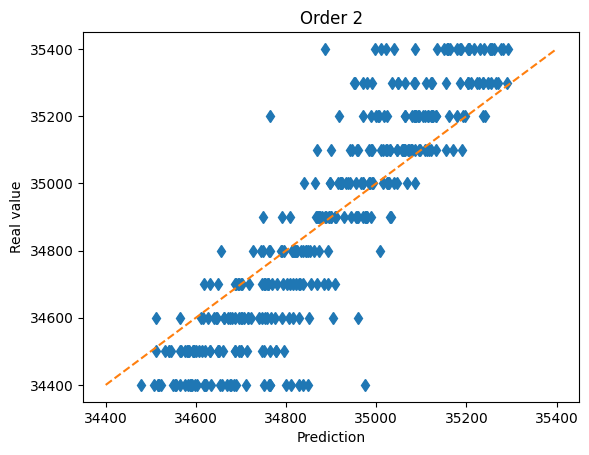

In [54]:
minval=X_test['order2'].min()
maxval=X_test['order2'].max()
yaux=np.linspace(minval,maxval,20)
xaux=yaux
plt.plot(X_predict_rf_backward[:,0],X_test['order2'],linestyle='None',marker='d')
plt.plot(xaux,yaux,linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('Real value')
plt.title('Order 2')

Text(0.5, 1.0, 'Order 3')

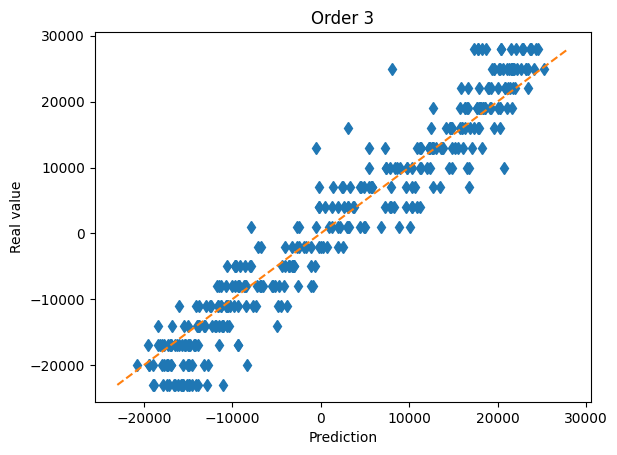

In [55]:
minval=X_test['order3'].min()
maxval=X_test['order3'].max()
yaux=np.linspace(minval,maxval,20)
xaux=yaux
plt.plot(X_predict_rf_backward[:,1],X_test['order3'],linestyle='None',marker='d')
plt.plot(xaux,yaux,linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('Real value')
plt.title('Order 3')

Text(0.5, 1.0, 'Order 4')

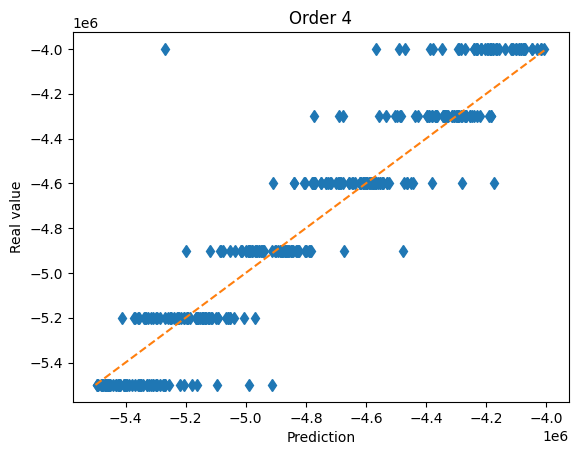

In [56]:
minval=X_test['order4'].min()
maxval=X_test['order4'].max()
yaux=np.linspace(minval,maxval,20)
xaux=yaux
plt.plot(X_predict_rf_backward[:,2],X_test['order4'],linestyle='None',marker='d')
plt.plot(xaux,yaux,linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('Real value')
plt.title('Order 4')

# PCA analysis

### Train the PCA (on the 100 points)

In [57]:
pca_comp=15
#normalize the pulse dataset
scaler=StandardScaler()
df_time_norm_100 = scaler.fit_transform(y_train_100) #only on the training set
#Train the pca space using the _morm
pca_100=PCA(n_components=pca_comp).fit(df_time_norm_100)
#convert to pca space
df_time_pca_100=pca_100.transform(df_time_norm_100)

Text(0, 0.5, 'cumulative explained variance')

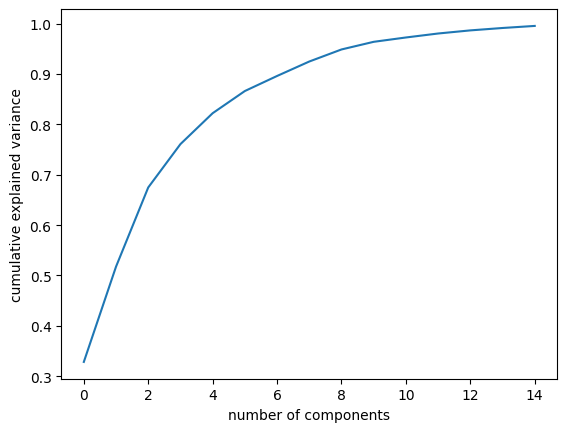

In [58]:
plt.plot(np.cumsum(pca_100.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0.5, 0, 'Component')

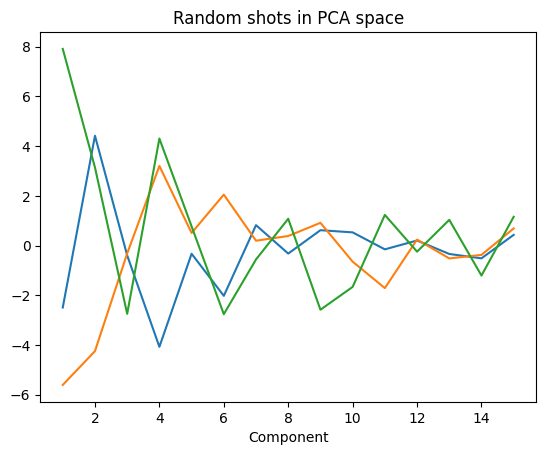

In [59]:
x_aux=np.linspace(1,pca_comp,pca_comp)
plt.plot(x_aux,df_time_pca_100[50])
plt.plot(x_aux,df_time_pca_100[20])
plt.plot(x_aux,df_time_pca_100[10])
plt.title('Random shots in PCA space')
plt.xlabel('Component')

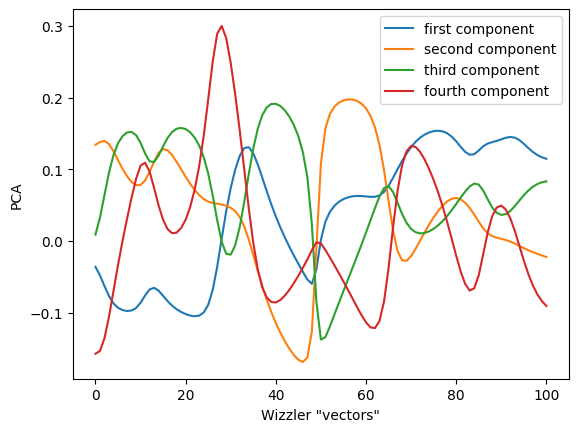

In [60]:
plt.plot(pca_100.components_[0],label='first component')
plt.plot(pca_100.components_[1],label='second component')
plt.plot(pca_100.components_[2],label='third component')
plt.plot(pca_100.components_[3],label='fourth component')
plt.xlabel('Wizzler "vectors"')
plt.ylabel('PCA')
plt.legend()

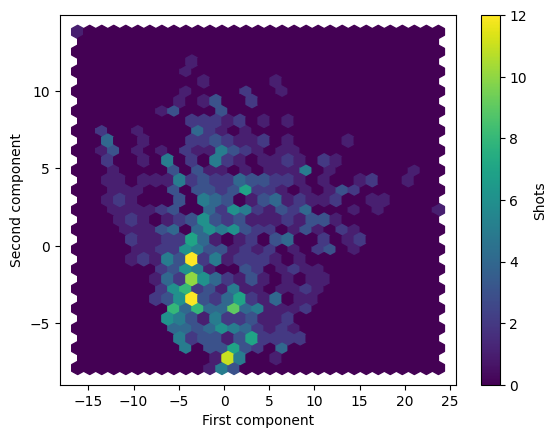

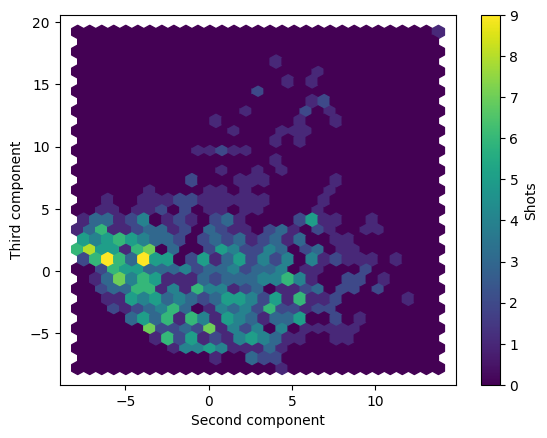

In [74]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca_100[:,0], df_time_pca_100[:,1],gridsize=30)#,cmap='jet')
#plt.plot(y_predict_pca[:,0],y_predict_pca[:,1],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
#plt.legend()
plt.show()

fig2, ax2 = plt.subplots()
h2=ax2.hexbin(df_time_pca_100[:,1], df_time_pca_100[:,2],gridsize=30)#,cmap='jet')
#plt.plot(y_predict_pca[:,0],y_predict_pca[:,1],marker='^',color='red',linestyle='None',label='Good performers')
ax2.set_xlabel('Second component')
ax2.set_ylabel('Third component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar2 =fig.colorbar(h2, ax=ax2)
cbar2.set_label('Shots')
#plt.legend()
plt.show()

Text(0, 0.5, 'Order 2')

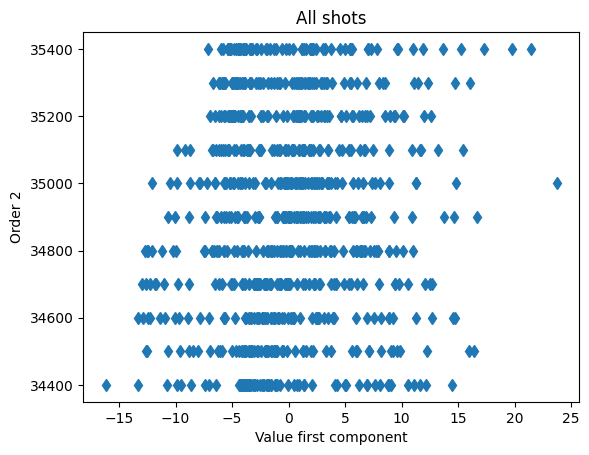

In [62]:
plt.plot(df_time_pca_100[:,0],X_train_100['order2'],linestyle='None', marker='d')
plt.title('All shots')
plt.xlabel('Value first component')
plt.ylabel('Order 2')

Text(0, 0.5, 'Order 3')

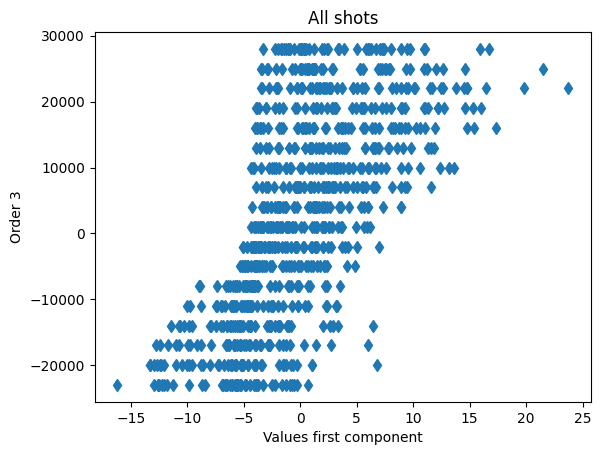

In [63]:
plt.plot(df_time_pca_100[:,0],X_train_100['order3'],linestyle='None', marker='d')
plt.title('All shots')
plt.xlabel('Values first component')
plt.ylabel('Order 3')

Text(0, 0.5, 'Order 4')

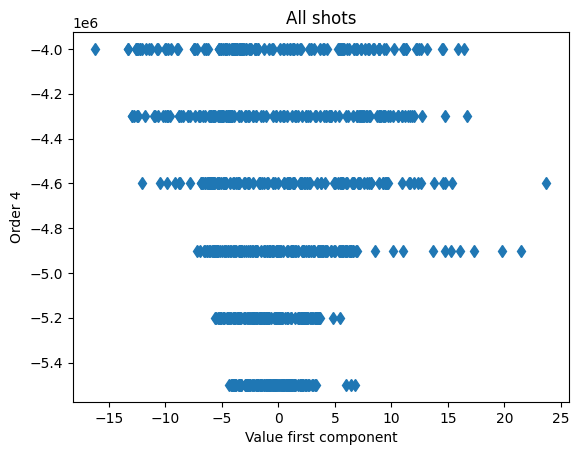

In [64]:
plt.plot(df_time_pca_100[:,0],X_train_100['order4'],linestyle='None', marker='d')
plt.title('All shots')
plt.xlabel('Value first component')
plt.ylabel('Order 4')

### Build custom shots ?

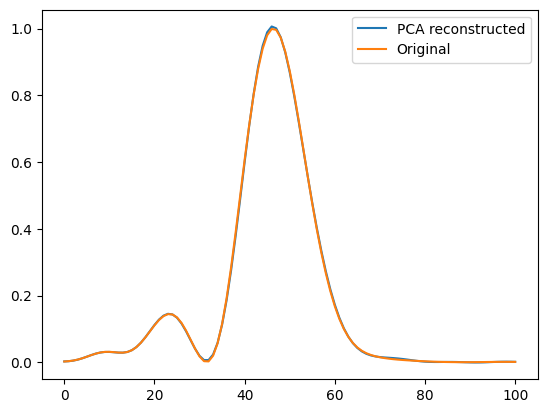

In [65]:
#test pca conversion
shot_ind=5
test_shot=y_test_100.iloc[shot_ind]
#test_shot.values
#Normalize the shot (with the same scaler as the PCA)
test_shot_norm=scaler.transform([test_shot.values])
#plt.plot(test_shot_norm[0])
#convert it to pca spcae
test_shot_pca=pca_100.transform(test_shot_norm)
#print(test_shot_pca)
#transfor it back to real space
test_shot_inv=pca_100.inverse_transform(test_shot_pca)
#rescale to original scale
test_shot_inv=scaler.inverse_transform(test_shot_inv)
plt.plot(test_shot_inv[0],label='PCA reconstructed')
plt.plot(test_shot,label='Original')
plt.legend()

In [66]:
#custom shot
test_shot_pca[0]

array([-7.57743908, -0.77642908,  4.96774247,  1.49703098, -0.51638919,
        0.68221266, -2.21200944,  1.1342211 , -1.0740782 , -1.80826016,
       -0.51531301,  1.08443992, -0.40026212, -0.75710331, -0.51086077])

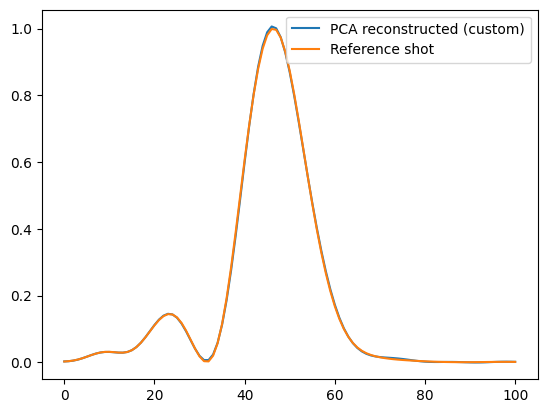

In [81]:
test_shot_pca=[-7.57743908, -0.77642908,  4.96774247,  1.49703098, -0.51638919,
        0.68221266, -2.21200944,  1.1342211 , -1.0740782 , -1.80826016,
       -0.51531301,  1.08443992, -0.40026212, -0.75710331, -0.51086077]
#transfor it back to real space
test_shot_inv=pca_100.inverse_transform([test_shot_pca])
#rescale to original scale
test_shot_inv=scaler.inverse_transform(test_shot_inv)
plt.plot(test_shot_inv[0],label='PCA reconstructed (custom)')
plt.plot(test_shot,label='Reference shot')
plt.legend()

In [ ]:
### PLOT THE CUSTOM SHOT IN THE PCA PARAMETER SPACE

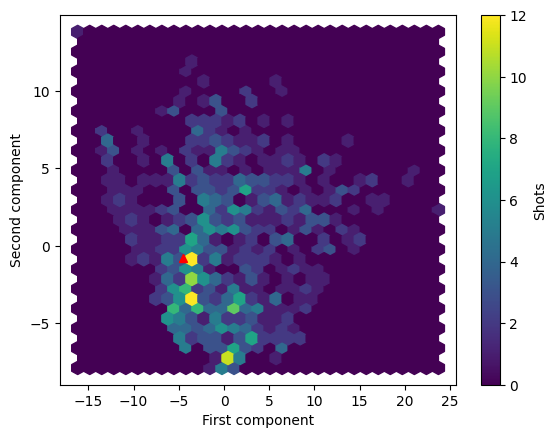

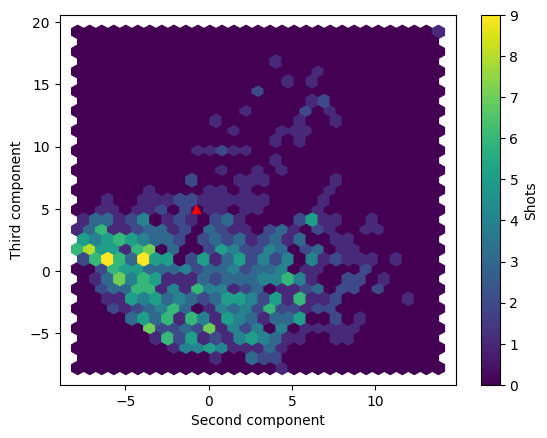

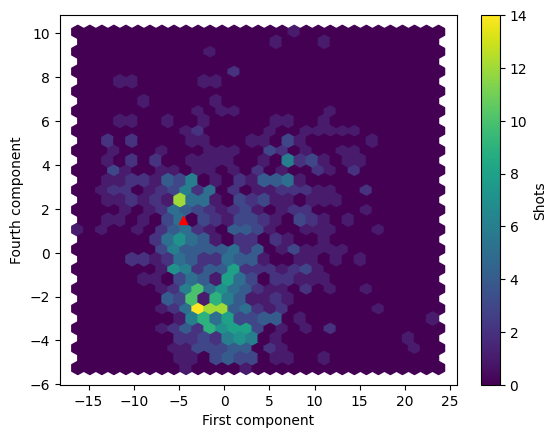

In [78]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca_100[:,0], df_time_pca_100[:,1],gridsize=30)#,cmap='jet')
plt.plot(test_shot_pca[0],test_shot_pca[1],marker='^',color='red',linestyle='None')#,label='Good performers')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
#plt.legend()
plt.show()

fig2, ax2 = plt.subplots()
h2=ax2.hexbin(df_time_pca_100[:,1], df_time_pca_100[:,2],gridsize=30)#,cmap='jet')
plt.plot(test_shot_pca[1],test_shot_pca[2],marker='^',color='red',linestyle='None')
ax2.set_xlabel('Second component')
ax2.set_ylabel('Third component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar2 =fig.colorbar(h2, ax=ax2)
cbar2.set_label('Shots')
#plt.legend()
plt.show()

fig3, ax3 = plt.subplots()
h3=ax3.hexbin(df_time_pca_100[:,0], df_time_pca_100[:,3],gridsize=30)#,cmap='jet')
plt.plot(test_shot_pca[0],test_shot_pca[3],marker='^',color='red',linestyle='None')
ax3.set_xlabel('First component')
ax3.set_ylabel('Fourth component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar3 =fig.colorbar(h3, ax=ax3)
cbar3.set_label('Shots')
#plt.legend()
plt.show()